<div><font size="4"><center><b>Dataset: ds10</b></center></font></div>

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import re
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.metrics import classification_report,accuracy_score

In [3]:
data= pd.read_csv("/content/drive/MyDrive/datasets/ds10.csv")

In [4]:
data=data.drop(['id'],axis=1)

In [5]:
data['content']=data['title']+" "+data['text']

In [6]:
data['content'] = data['content'].astype(str)

In [8]:
data.head()

,title,author,text,label,content
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [11]:
#performing stemming
from nltk.stem.porter import PorterStemmer

In [13]:
port_stem = PorterStemmer()
stop_words = set(stopwords.words('english'))
pattern = re.compile('[^a-zA-Z]')
def stemming(content, pattern, stop_words, stemmer):
  stem_content = pattern.sub(' ', content)
  stem_content = stem_content.lower().split()
  stem_content = [stemmer.stem(word) for word in stem_content if word not in stop_words]
  stem_content = ' '.join(stem_content)
  return stem_content

In [14]:
# applying the optimized stemming function to the content
data['content'] = data['content'].apply(stemming, args=(pattern, stop_words, port_stem))

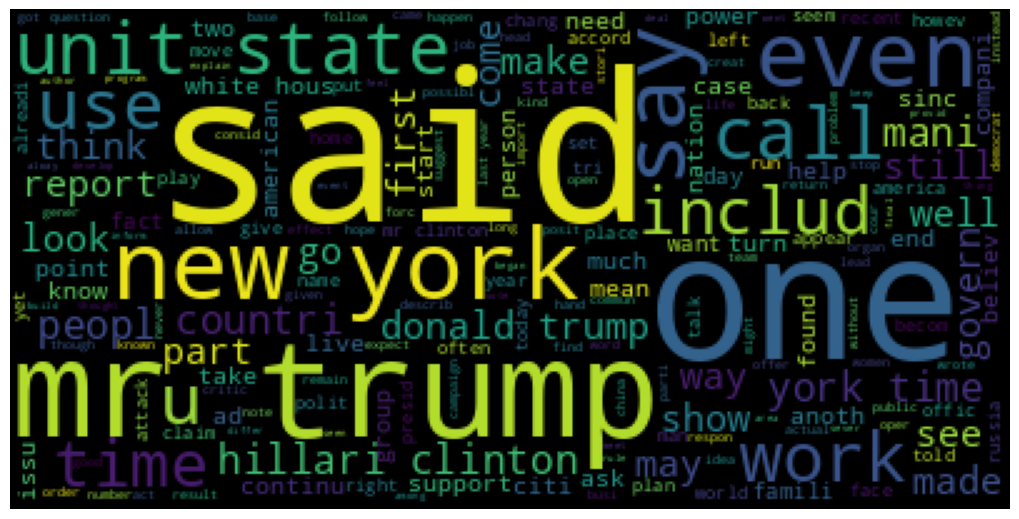

In [15]:
#wordcloud
content= ' '.join(data['content'].tolist())
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate(content)
fig= plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [17]:
#vectorization  using word2vec
X = [d.split() for d in data['content'].tolist()]

In [18]:
import gensim

DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [20]:
w2v_model.wv.most_similar('us')

[('let', 0.5630371570587158),
 ('america', 0.508075475692749),
 ('rest', 0.5046424865722656),
 ('therefor', 0.504514217376709),
 ('truth', 0.5024219751358032),
 ('must', 0.4981394112110138),
 ('sake', 0.4978063404560089),
 ('unfortun', 0.49364638328552246),
 ('inde', 0.49232834577560425),
 ('truli', 0.4852150082588196)]

In [21]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(X)
X= tokenizer.texts_to_sequences(X)

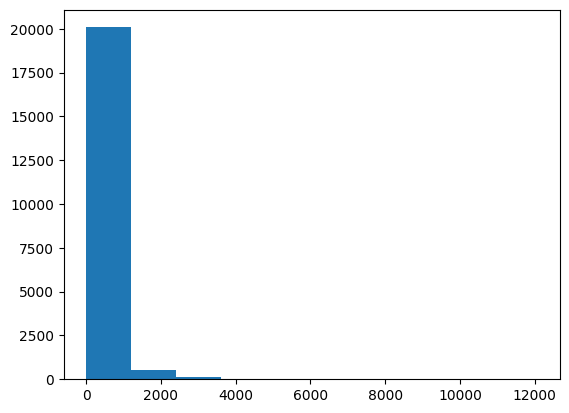

In [22]:
plt.hist([len(x) for x in X],bins = 10)
plt.show()

In [23]:
#now for padding the sequences
nos= np.array([len(X) for x in X])
len(nos[nos>1500])
maxlen=1500
X= pad_sequences(X,maxlen=maxlen)

In [24]:
X.shape

(20800, 1500)

In [25]:
X[0]

array([    0,     0,     0, ..., 12591, 22167,   633], dtype=int32)

In [26]:
#assigning the weights
vocab_size= len(tokenizer.word_index)+1
vocab= tokenizer.word_index

In [27]:
def get_weight_matrix(model):
  
    weight_matrix = np.zeros((vocab_size, DIM))
   
    for word,i in vocab.items():

        weight_matrix[i] = model.wv[word]

    return weight_matrix

In [28]:
embedding_vectors = get_weight_matrix(w2v_model)

In [29]:
embedding_vectors.shape


(110486, 100)

In [30]:
Y= data['label'].values

In [31]:
##################################.   LSTM model.  #####################################################

In [32]:
model= Sequential()

In [33]:
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors],input_length= maxlen, trainable= False))
model.add(LSTM(units=128))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(optimizer='adam', loss= 'binary_crossentropy',metrics= ['acc'])

In [34]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size =0.2)

In [35]:
#training the model
model.fit(X_train,Y_train, validation_split=0.3, epochs=6)

Epoch 1/6
364/364 [==============================] - 29s 60ms/step - loss: 0.3042 - acc: 0.8726 - val_loss: 0.2308 - val_acc: 0.9195
Epoch 2/6
364/364 [==============================] - 20s 54ms/step - loss: 0.1926 - acc: 0.9273 - val_loss: 0.1822 - val_acc: 0.9327
Epoch 3/6
364/364 [==============================] - 21s 57ms/step - loss: 0.1347 - acc: 0.9503 - val_loss: 0.4108 - val_acc: 0.8472
Epoch 4/6
364/364 [==============================] - 19s 51ms/step - loss: 0.1425 - acc: 0.9452 - val_loss: 0.1392 - val_acc: 0.9497
Epoch 5/6
364/364 [==============================] - 18s 51ms/step - loss: 0.1049 - acc: 0.9613 - val_loss: 0.1197 - val_acc: 0.9527
Epoch 6/6
364/364 [==============================] - 22s 59ms/step - loss: 0.0850 - acc: 0.9706 - val_loss: 0.1227 - val_acc: 0.9539


In [36]:
#checking on test dataset
y_pred= (model.predict(X_test)>=0.5).astype(int)
Lstm_acc = accuracy_score(Y_test,y_pred)
print(Lstm_acc)

130/130 [==============================] - 3s 18ms/step
0.9483173076923077


In [37]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2082
           1       0.94      0.95      0.95      2078

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160



In [38]:
#overall model accuracy came out to be 99% for LSTM standard

In [39]:
#now for randomly testing any news
Z=['WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, said Department of Justice Special Counsel Robert Mueller needs to carry on with his Russia investigation without political interference. “This investigation will go forward. It will be an investigation conducted without political influence,” Graham said on CBS’s Face the Nation news program. “And we all need to let Mr. Mueller do his job. I think he’s the right guy at the right time.”  The question of how Russia may have interfered in the election, and how Trump’s campaign may have had links with or co-ordinated any such effort, has loomed over the White House since Trump took office in January. It shows no sign of receding as Trump prepares for his second year in power, despite intensified rhetoric from some Trump allies in recent weeks accusing Mueller’s team of bias against the Republican president. Trump himself seemed to undercut his supporters in an interview last week with the New York Times in which he said he expected Mueller was “going to be fair.”    Russia’s role in the election and the question of possible links to the Trump campaign are the focus of multiple inquiries in Washington. Three committees of the Senate and the House of Representatives are investigating, as well as Mueller, whose team in May took over an earlier probe launched by the U.S. Federal Bureau of Investigation (FBI). Several members of the Trump campaign and administration have been convicted or indicted in the investigation.  Trump and his allies deny any collusion with Russia during the campaign, and the Kremlin has denied meddling in the election. Graham said he still wants an examination of the FBI’s use of a dossier on links between Trump and Russia that was compiled by a former British spy, Christopher Steele, which prompted Trump allies and some Republicans to question Mueller’s inquiry.   On Saturday, the New York Times reported that it was not that dossier that triggered an early FBI probe, but a tip from former Trump campaign foreign policy adviser George Papadopoulos to an Australian diplomat that Russia had damaging information about former Trump rival Hillary Clinton.  “I want somebody to look at the way the Department of Justice used this dossier. It bothers me greatly the way they used it, and I want somebody to look at it,” Graham said. But he said the Russia investigation must continue. “As a matter of fact, it would hurt us if we ignored it,” he said.']

In [40]:
Z= tokenizer.texts_to_sequences(Z)
Z=pad_sequences(Z,maxlen=maxlen)

In [41]:
print( (model.predict(Z)>=0.5).astype(int))

1/1 [==============================] - 0s 359ms/step
[[1]]


In [42]:
# using different models on same dataset

In [43]:
##################################.  Bidirectional LSTM model.  #####################################################

In [44]:
#2. using the bidrectional LSTM

In [45]:
from keras.layers import Bidirectional

model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['acc'])

In [46]:
#training the model
model.fit(X_train,Y_train, validation_split=0.3, epochs=20)

Epoch 1/20


364/364 [==============================] - 17s 32ms/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6933 - val_acc: 0.5012
Epoch 2/20
364/364 [==============================] - 13s 35ms/step - loss: 0.6931 - acc: 0.5064 - val_loss: 0.6932 - val_acc: 0.4988
Epoch 3/20
364/364 [==============================] - 13s 35ms/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.5012
Epoch 4/20
364/364 [==============================] - 13s 35ms/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.4988
Epoch 5/20
364/364 [==============================] - 13s 34ms/step - loss: 0.6932 - acc: 0.4905 - val_loss: 0.6932 - val_acc: 0.4988
Epoch 6/20
364/364 [==============================] - 10s 28ms/step - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.4988
Epoch 7/20
364/364 [==============================] - 11s 31ms/step - loss: 0.6932 - acc: 0.4949 - val_loss: 0.6931 - val_acc: 0.5012
Epoch 8/20
364/364 [==============================] - 11s 30ms/step - los

In [47]:
#checking on test dataset
y_pred= (model.predict(X_test)>=0.5).astype(int)
Blstm_acc= accuracy_score(Y_test,y_pred)
print(Blstm_acc)

130/130 [==============================] - 4s 19ms/step
0.49951923076923077


In [48]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2082
           1       0.50      1.00      0.67      2078

    accuracy                           0.50      4160
   macro avg       0.25      0.50      0.33      4160
weighted avg       0.25      0.50      0.33      4160



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
############################################.   CNN model  .#####################################################

In [50]:
#using CNN model
X.shape

(20800, 1500)

In [51]:
Y.shape

(20800,)

In [52]:
#using CNN model
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size =0.2)

In [53]:
print(X_train.shape)
print(Y_train.shape)

(16640, 1500)
(16640,)


In [54]:
# reshape input data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))

# Verify new input shapes
print(X_train.shape)
print(Y_train.shape)

(16640, 1500, 1)
(16640, 1)


In [55]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# define model architecture
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(X_train, Y_train, validation_split=0.3, epochs=10)

Epoch 1/10
364/364 [==============================] - 10s 8ms/step - loss: 9.0151 - accuracy: 0.5492 - val_loss: 0.6859 - val_accuracy: 0.5092
Epoch 2/10
364/364 [==============================] - 2s 5ms/step - loss: 0.6737 - accuracy: 0.6138 - val_loss: 0.6526 - val_accuracy: 0.6244
Epoch 3/10
364/364 [==============================] - 2s 6ms/step - loss: 0.6428 - accuracy: 0.6306 - val_loss: 0.6345 - val_accuracy: 0.6340
Epoch 4/10
364/364 [==============================] - 2s 6ms/step - loss: 0.6392 - accuracy: 0.6368 - val_loss: 0.6348 - val_accuracy: 0.6364
Epoch 5/10
364/364 [==============================] - 2s 6ms/step - loss: 0.6355 - accuracy: 0.6355 - val_loss: 0.6298 - val_accuracy: 0.6372
Epoch 6/10
364/364 [==============================] - 3s 8ms/step - loss: 0.6333 - accuracy: 0.6340 - val_loss: 0.6415 - val_accuracy: 0.6306
Epoch 7/10
364/364 [==============================] - 2s 6ms/step - loss: 0.6328 - accuracy: 0.6342 - val_loss: 0.6381 - val_accuracy: 0.6314
Epoch

In [56]:
#changing the laarning rate and optimizer to see if the accuracy improves

In [57]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()

# Add a Conv1D layer with 64 filters and kernel size of 5
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# Add a MaxPooling1D layer with pool size of 2
model.add(MaxPooling1D(pool_size=2))
# Add a BatchNormalization layer to normalize the output of the Conv1D layer
model.add(BatchNormalization())

# Add another Conv1D layer with 32 filters and kernel size of 3
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# Add another MaxPooling1D layer with pool size of 2
model.add(MaxPooling1D(pool_size=2))
# Add another BatchNormalization layer
model.add(BatchNormalization())

# Add a third Conv1D layer with 16 filters and kernel size of 3
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
# Add another MaxPooling1D layer with pool size of 2
model.add(MaxPooling1D(pool_size=2))
# Add another BatchNormalization layer
model.add(BatchNormalization())

# Flatten the output of the Conv1D layers
model.add(Flatten())
# Add a Dropout layer with rate of 0.5 to prevent overfitting
model.add(Dropout(0.5))

# Add a Dense layer with 256 units and 'relu' activation
model.add(Dense(256, activation='relu'))
# Add another Dropout layer
model.add(Dropout(0.5))
# Add a Dense layer with 1 unit and 'sigmoid' activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [58]:
# Compile the model with Adam optimizer and binary crossentropy loss function
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [59]:
# Fit the model on the training data for 50 epochs
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/50
260/260 [==============================] - 5s 13ms/step - loss: 0.8005 - accuracy: 0.6162 - val_loss: 0.6517 - val_accuracy: 0.6505
Epoch 2/50
260/260 [==============================] - 3s 10ms/step - loss: 0.6366 - accuracy: 0.6454 - val_loss: 0.6218 - val_accuracy: 0.6507
Epoch 3/50
260/260 [==============================] - 3s 11ms/step - loss: 0.6051 - accuracy: 0.6535 - val_loss: 0.5919 - val_accuracy: 0.6656
Epoch 4/50
260/260 [==============================] - 3s 11ms/step - loss: 0.5915 - accuracy: 0.6632 - val_loss: 0.5982 - val_accuracy: 0.6599
Epoch 5/50
260/260 [==============================] - 3s 11ms/step - loss: 0.5773 - accuracy: 0.6689 - val_loss: 0.6028 - val_accuracy: 0.6550
Epoch 6/50
260/260 [==============================] - 3s 11ms/step - loss: 0.5722 - accuracy: 0.6752 - val_loss: 0.5881 - val_accuracy: 0.6714
Epoch 7/50
260/260 [==============================] - 3s 11ms/step - loss: 0.5662 - accuracy: 0.6781 - val_loss: 0.5908 - val_accuracy: 0.6695

In [60]:
Cnn_acc = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (Cnn_acc[1]*100))

Accuracy: 70.99%


In [61]:
#fcn

In [62]:
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()

# Add a Dense layer with 64 units and 'relu' activation, and input shape of (X_train.shape[1],)
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
# Add a BatchNormalization layer to normalize the output of the Dense layer
model.add(BatchNormalization())

# Add another Dense layer with 32 units and 'relu' activation
model.add(Dense(units=32, activation='relu'))
# Add another BatchNormalization layer
model.add(BatchNormalization())

# Add a third Dense layer with 16 units and 'relu' activation
model.add(Dense(units=16, activation='relu'))
# Add another BatchNormalization layer
model.add(BatchNormalization())

# Add a Dropout layer with rate of 0.5 to prevent overfitting
model.add(Dropout(0.5))

# Add a Dense layer with 256 units and 'relu' activation
model.add(Dense(units=256, activation='relu'))
# Add another Dropout layer
model.add(Dropout(0.5))
# Add a Dense layer with 1 unit and 'sigmoid' activation for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [63]:
# Fit the model on the training data for 50 epochs
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/50
260/260 [==============================] - 2s 5ms/step - loss: 0.6859 - accuracy: 0.5829 - val_loss: 0.6394 - val_accuracy: 0.6387
Epoch 2/50
260/260 [==============================] - 1s 4ms/step - loss: 0.6451 - accuracy: 0.6383 - val_loss: 0.6300 - val_accuracy: 0.6442
Epoch 3/50
260/260 [==============================] - 1s 4ms/step - loss: 0.6196 - accuracy: 0.6620 - val_loss: 0.6288 - val_accuracy: 0.6351
Epoch 4/50
260/260 [==============================] - 1s 4ms/step - loss: 0.5876 - accuracy: 0.6897 - val_loss: 0.6287 - val_accuracy: 0.6438
Epoch 5/50
260/260 [==============================] - 1s 4ms/step - loss: 0.5522 - accuracy: 0.7194 - val_loss: 0.6383 - val_accuracy: 0.6445
Epoch 6/50
260/260 [==============================] - 1s 4ms/step - loss: 0.5120 - accuracy: 0.7486 - val_loss: 0.6655 - val_accuracy: 0.6358
Epoch 7/50
260/260 [==============================] - 2s 6ms/step - loss: 0.4759 - accuracy: 0.7760 - val_loss: 0.6764 - val_accuracy: 0.6349
Epoch 

In [64]:
Fcn_acc = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (Fcn_acc[1]*100))

Accuracy: 63.73%


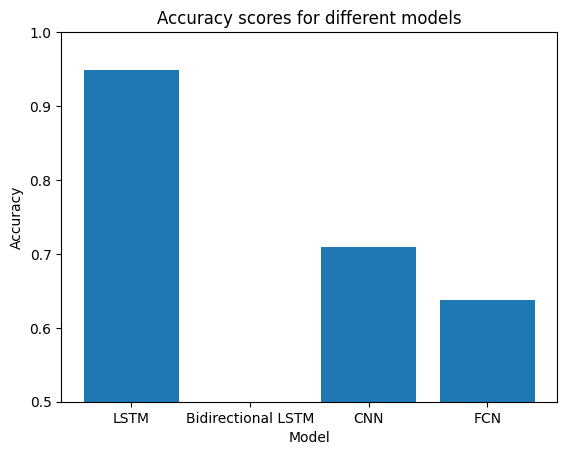

In [65]:
import matplotlib.pyplot as plt

models = ['LSTM', 'Bidirectional LSTM', 'CNN', 'FCN']
accuracy_scores = [Lstm_acc, Blstm_acc, Cnn_acc[1], Fcn_acc[1]]

# Flatten the accuracy_scores list
accuracy_scores = [score[0] if isinstance(score, list) else score for score in accuracy_scores]

plt.bar(models, accuracy_scores)
plt.title('Accuracy scores for different models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.show()

<font size="4">From the above graph it can be noted that LSTM has the largest accuracy=0.9483173076923077</font>

In [1]:
# Statistical Testing

In [67]:
import numpy as np
from scipy.stats import friedmanchisquare


model_scores = [np.array([Lstm_acc]), np.array([Blstm_acc]), np.array([Cnn_acc[1]]), np.array([Fcn_acc[1]])]

friedman_value, p_value = friedmanchisquare(*model_scores)

print("Friedman test")
print("--------------")
print("Friedman value:", friedman_value)
print("p-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference in the test accuracy scores of the models.")
else:
    print("There is no significant difference in the test accuracy scores of the models.")

Friedman test
--------------
Friedman value: 3.0
p-value: 0.3916251762710877
There is no significant difference in the test accuracy scores of the models.


In [68]:
import numpy as np
from scipy.stats import chisquare

model_scores = [Lstm_acc, Blstm_acc, Cnn_acc[1], Fcn_acc[1]]

expected_score = np.mean(model_scores)

# Calculate the chi-squared test statistic and p-value
chi_stat, p_value = chisquare(model_scores, f_exp=expected_score)

print("Chi-squared test results")
print("-------------------------")
print("Chi-squared statistic:", chi_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference in the test accuracy scores of the models.")
else:
    print("There is no significant difference in the test accuracy scores of the models.")

Chi-squared test results
-------------------------
Chi-squared statistic: 0.15153197620101244
p-value: 0.9850059811433349
There is no significant difference in the test accuracy scores of the models.


In [69]:
import numpy as np
from scipy.stats import ttest_rel

model_scores = [Lstm_acc, Blstm_acc, Cnn_acc[1], Fcn_acc[1]]

# Perform the paired t-test
t_stat, p_value = ttest_rel(model_scores[:-1], model_scores[1:])

print("Paired t-test results")
print("----------------------")
print("t-statistic:", t_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference in the test accuracy scores of the models.")
else:
    print("There is no significant difference in the test accuracy scores of the models.")

Paired t-test results
----------------------
t-statistic: 0.5431148812788319
p-value: 0.6414887080783223
There is no significant difference in the test accuracy scores of the models.
